In [18]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
from matplotlib.patches import Patch

In [19]:
data_path = '/data/willett_data/paper_results/'

In [20]:
def rename_keys_by_map(d, key_map):
    """
    Renames keys in a dictionary using a mapping from old to new keys.

    Args:
        d (dict): Original dictionary.
        key_map (dict): Mapping from old keys to new keys.

    Returns:
        dict: Dictionary with renamed keys.
    """
    return {key_map.get(k, k): v for k, v in d.items()}

def reorder_dict(d, key_order):
    """
    Returns a new dict with keys ordered as specified in key_order.

    Args:
        d (dict): The original dictionary.
        key_order (list): Desired order of keys.

    Returns:
        dict: Reordered dictionary.
    """
    return {k: d[k] for k in key_order if k in d}

In [42]:
with open(data_path + 'ventral_dict_comp.pkl', 'rb') as f:
    ventral_6v_perf = pickle.load(f)

with open(data_path + 'ventral_dict_val.pkl', 'rb') as f:
    ventral_6v_perf_val = pickle.load(f)
    
replace_keys = {'neurips_gru_ventral_6v_only_seed_': 'GRU',
                'neurips_transformer_time_masked_ventral_6v_only_seed_': 'Transformer'}

ventral_6v_perf = rename_keys_by_map(ventral_6v_perf, replace_keys)
print(ventral_6v_perf)


held_out_days_perf = {'GRU': [46.109, 46.366, 46.812, 46.082], 
                     'Transformer': [43.362, 43.497, 42.374, 42.563]}

restricted_days_perf = {'GRU': [26.688, 26.972, 26.688, 27.081], 
                     'Transformer': [23.657, 22.926, 23.17, 22.872]}

{'GRU': [21.302, 21.194, 21.573], 'Transformer': [17.58, 18.5, 18.162, 17.255]}


In [196]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.colors import to_rgba
def plot_model_perf_with_benchmark(
    fig,
    axes,
    idx,
    data_dict,
    transf_orig_perf,
    gru_orig_perf,
    title,
    show_legend=True,
):
    """Draw a bar‑plus‑strip plot on the idx‑th Axes inside fig."""
    # ---------- tidy to long‑form DataFrame ----------
    df = pd.DataFrame(
        [{"Model": m, "Error Rate": v}
         for m, vals in data_dict.items()
         for v in vals]
    )
    model_means = df.groupby("Model")["Error Rate"].mean()
    print(f"\n== {title} ==")
    for model, mean_val in model_means.items():
        if model == 'GRU':
            print(f"{model}: {mean_val:.2f} {gru_orig_perf - mean_val:.2f}%")
        else:
            print(f"{model}: {mean_val:.2f} {transf_orig_perf - mean_val:.2f}%")
            
        
    from matplotlib import cm
    colors = cm.Blues(np.linspace(0.2, 0.5, 4))
    colors[-1] = to_rgba("#c2a5cf") 

    palette = {
        "Transformer": colors[-1],  # lighter blue
        "GRU":         colors[0],  # lighter purple
    }

    ax = axes[idx]
    ax.clear()

    # ---------- mean bars ----------
    sns.barplot(
        data=df,
        x="Model", y="Error Rate",
        hue="Model",           # required so palette works w/o warning
        dodge=False, legend=False,
        estimator="mean", errorbar=None,
        palette=palette, width=0.5,
        ax=ax, zorder=0
    )

    # ---------- individual seeds ----------
    sns.stripplot(
        data=df,
        x="Model", y="Error Rate",
        jitter=True, dodge=False,
        linewidth=1, edgecolor="none",
        color="black",          # single colour → no palette warning
        size=8, ax=ax, zorder=1
    )

    # ---------- dashed baseline lines ----------
    bar_positions = [p.get_x() + p.get_width() / 2
                     for p in ax.patches if isinstance(p, plt.Rectangle)]
    bar_width = ax.patches[0].get_width() if ax.patches else 0.5

    
    # ---------- legend & axes cosmetics ----------
    if show_legend:
        labels = ["Baseline", "Transformer"]
        bars = [bar for bar in ax.patches if isinstance(bar, plt.Rectangle) and bar.get_y() == 0]
        for bar, label in zip(bars, labels):
            x = bar.get_x() + bar.get_width() / 2
            y = bar.get_height()
            if label == 'Baseline':
                y_drop = 7
            else:
                y_drop = 4
            ax.text(
                x, y - y_drop,  # lower the label below the bar
                label,
                ha="center", va="top",
                fontsize=18, fontweight='bold',
                rotation=90, color='black'
            )


    if len(bar_positions) >= 2:
        
        if idx > 0:
            ax.hlines(transf_orig_perf,
                    bar_positions[1] - bar_width/2,
                    bar_positions[1] + bar_width/2,
                    color="black", linestyle="--", linewidth=2)
            
        else:
                
            gap = 0.1  # Adjust for how wide the gap should be
            center = bar_positions[1]
            left = center - bar_width / 2
            right = (center + bar_width / 2) - 0.003

            # Left segment (before the gap)
            ax.hlines(
                y=transf_orig_perf,
                xmin=left,
                xmax=center - gap + 0.04,
                color="black", linestyle="--", linewidth=2
            )

            # Right segment (after the gap)
            ax.hlines(
                y=transf_orig_perf,
                xmin=center + gap - 0.05,
                xmax=right,
                color="black", linestyle="--", linewidth=2
            )
        
        ax.hlines(gru_orig_perf,
                  bar_positions[0] - bar_width/2,
                  bar_positions[0] + bar_width/2,
                  color="black", linestyle="--", linewidth=2)
        
        

    ax.set_title(title, fontsize=18)
    if idx == 0:
        ax.set_ylabel("Word Error Rate (%)", fontsize=18)
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.tick_params(axis='y', labelsize=16)
    sns.despine(ax=ax)
    fig.tight_layout()


In [197]:
baseline_perf = 15.2764
transformer_perf = 12.271



== Ventral 6v Only ==
GRU: 21.36 -6.08%
Transformer: 17.87 -5.60%

== Lower training data ==
GRU: 26.86 -11.58%
Transformer: 23.16 -10.89%

== Evaluation on Held-Out Days ==
GRU: 46.34 -31.07%
Transformer: 42.95 -30.68%


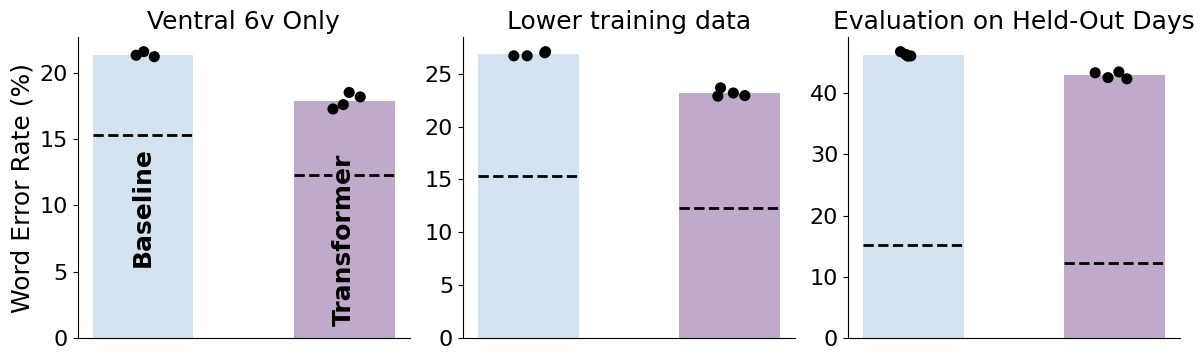

In [198]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3.7))

plot_model_perf_with_benchmark(fig, axs, 0, ventral_6v_perf, 
                               transf_orig_perf=transformer_perf, gru_orig_perf=baseline_perf, title='Ventral 6v Only', show_legend=True)


plot_model_perf_with_benchmark(fig, axs, 1, restricted_days_perf, 
                               transf_orig_perf=transformer_perf, gru_orig_perf=baseline_perf, title='Lower training data', show_legend=False)


plot_model_perf_with_benchmark(fig, axs, 2, held_out_days_perf, transf_orig_perf=transformer_perf,
                               gru_orig_perf=baseline_perf, title='Evaluation on Held-Out Days', show_legend=False)

plt.savefig('/home3/ebrahim2/neural_seq_decoder/notebooks/figures/figure_pdf/figure2/robustness.pdf', bbox_inches='tight')

In [192]:
21.36 - 15.2764

6.083599999999999